# 01. Exploratory Data Analysis (EDA)

**Objective:** Understand the data structure, distributions, and relationships to inform the modeling strategy.

**Methodology:** 
To prevent **Data Leakage**, we will perform EDA **exclusively** on the Training set. The Validation set must remain unseen until evaluation.

In [8]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import sys
import os

# Add project root to path
sys.path.append(os.path.abspath('..'))

from src.sml_homework.data_loader import load_and_split_data
from src.sml_homework.visualization import (
    plot_target_distribution,
    plot_numerical_distributions,
    plot_categorical_distributions,
    plot_correlation_heatmap,
    plot_boxplots,
    plot_scatter
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load and Prepare Data for Analysis

We load the data and immediately split it using `stratified split`. We then recombine the training features and target into a single DataFrame `train_df` for visualization purposes.

In [9]:
X_train, X_val, y_train, y_val = load_and_split_data('../data/raw/train.csv')

# Recombine X and y for EDA plotting
train_df = X_train.copy()
train_df['loan_paid_back'] = y_train

print(f"Training Data Shape: {train_df.shape}")
print(f"Validation Data Shape: {X_val.shape} (Reserved)")

Training Data Shape: (475195, 13)
Validation Data Shape: (118799, 12) (Reserved)


In [19]:
train_df.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
501345,501345,50302.46,0.179,726,7953.32,12.02,Female,Single,Bachelor's,Retired,Car,C2,1.0
314826,314826,55926.72,0.063,668,29208.02,14.33,Female,Married,Bachelor's,Employed,Debt consolidation,D3,1.0
69984,69984,23982.10,0.128,767,18153.50,11.24,Female,Single,Master's,Self-employed,Education,B1,1.0
126716,126716,52879.03,0.068,723,13481.78,9.81,Female,Married,Bachelor's,Employed,Debt consolidation,C5,1.0
42799,42799,24312.14,0.071,690,10613.62,13.12,Female,Married,Bachelor's,Employed,Debt consolidation,C1,1.0


## 2. Target Variable Analysis (Class Imbalance)

Checking `loan_paid_back` because imbalanced classes can bias the model.

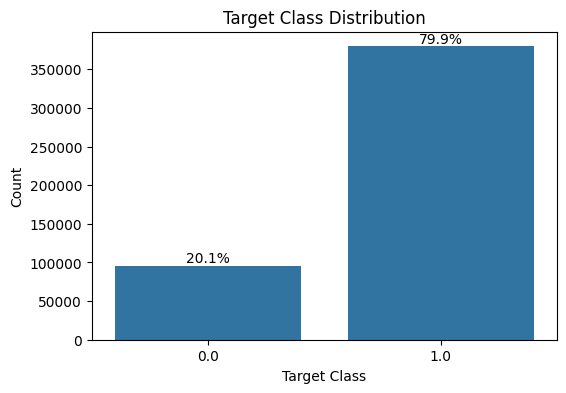

In [10]:
plot_target_distribution(train_df['loan_paid_back'])

## 3. Numerical Feature Analysis

Analyzing skewness and distributions. Skewed features may require Log Transformation.

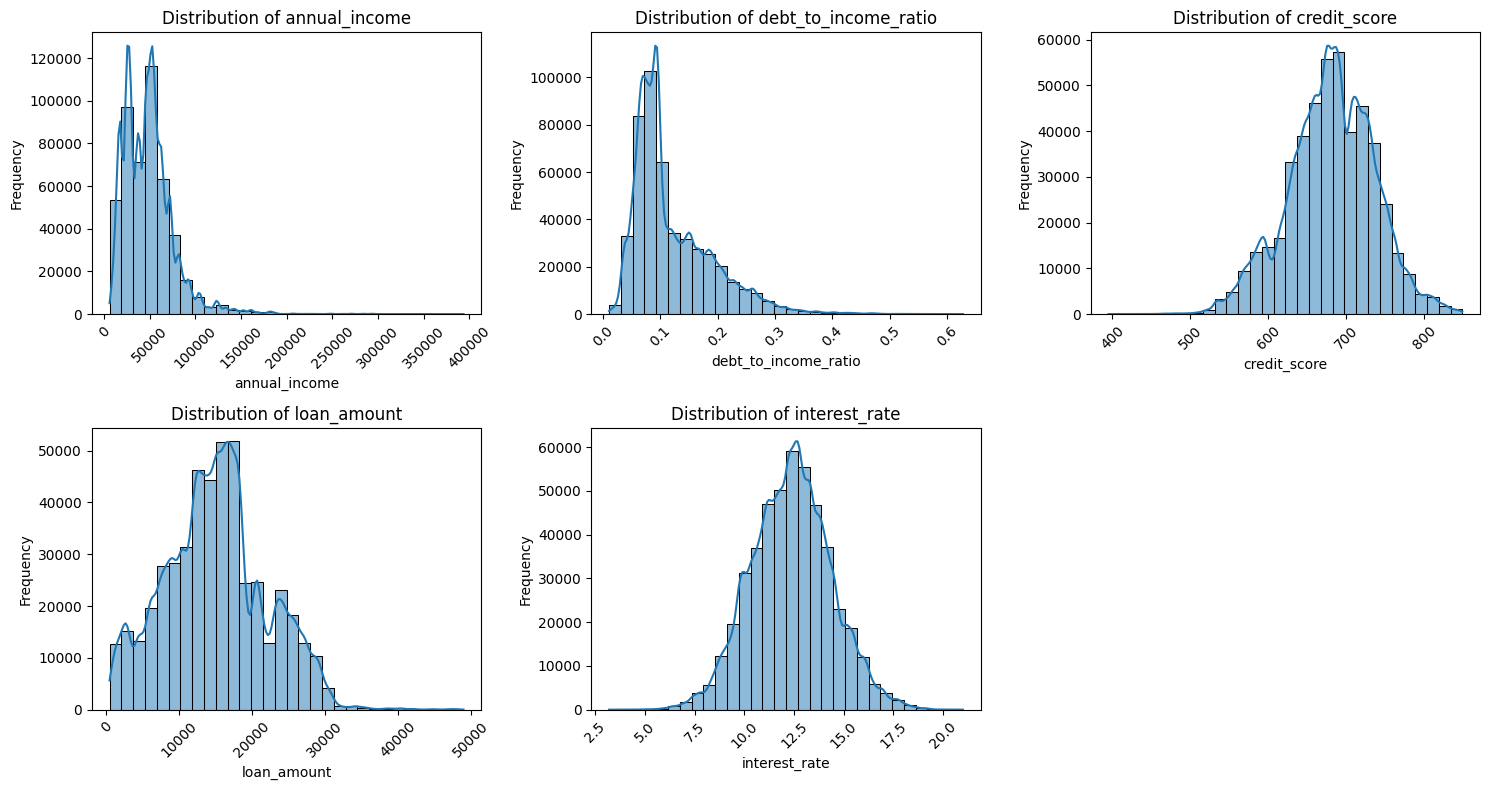

In [11]:
plot_numerical_distributions(train_df)

### Outlier Detection
Using Box Plots to identify extreme values in `annual_income` or `debt_to_income_ratio`.

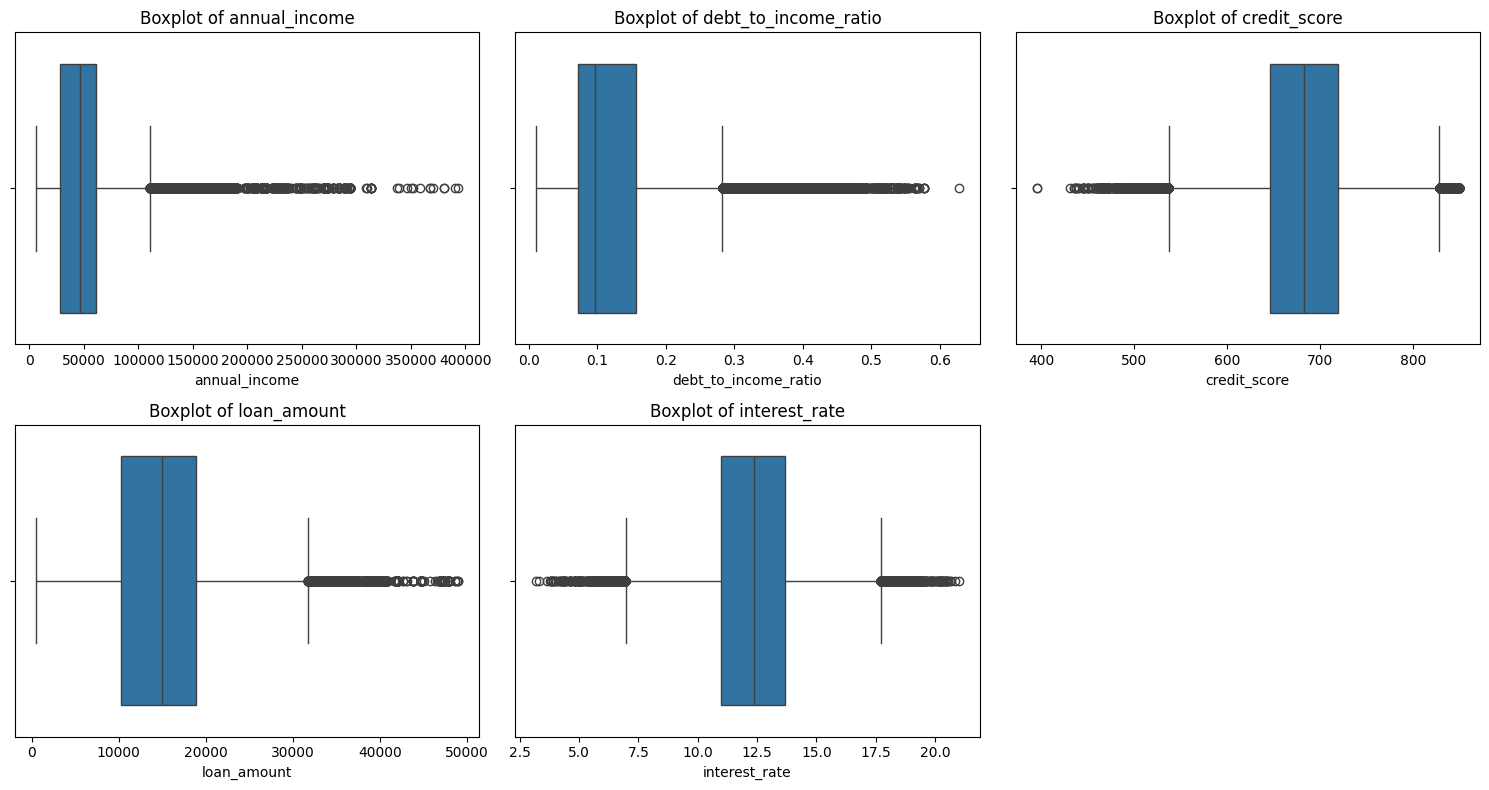

In [12]:
plot_boxplots(train_df)

## 4. Categorical Feature Analysis

Examining cardinality. High cardinality in `grade_subgrade` suggests we should use **Concept Hierarchy Climbing** to group them into `grade`.

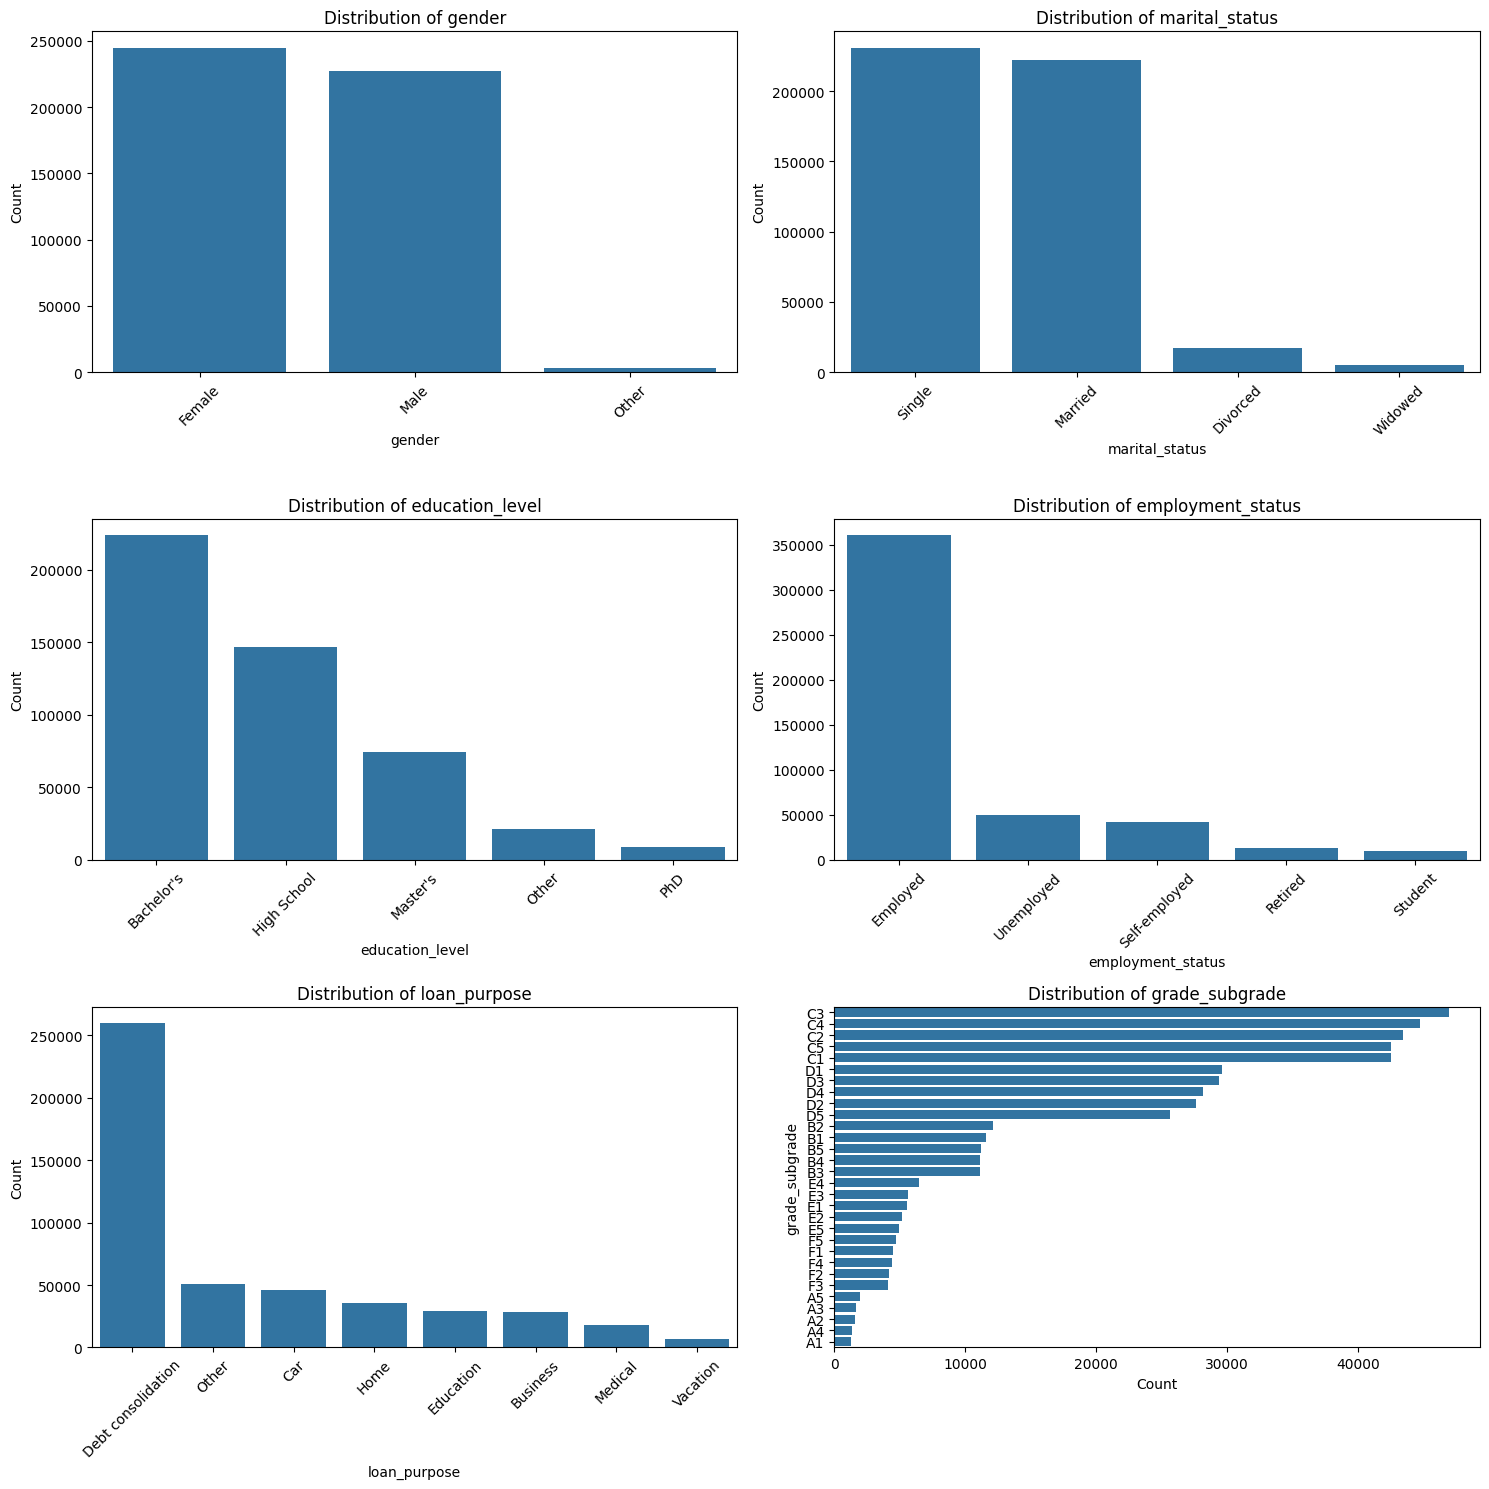

In [13]:
plot_categorical_distributions(train_df)

## 5. Correlation Analysis

We use **Pearson** correlation for continuous features and **Spearman** for potential ordinal relationships.

Pearson Correlation (Continuous Variables):


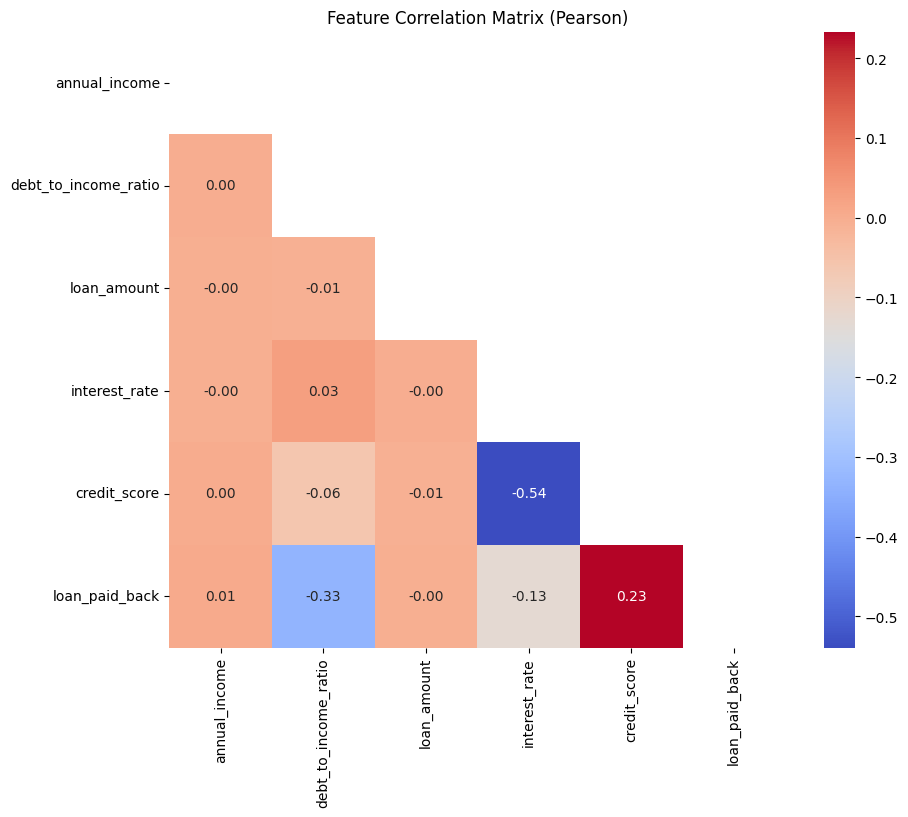

Spearman Correlation (Ordinal Variables):


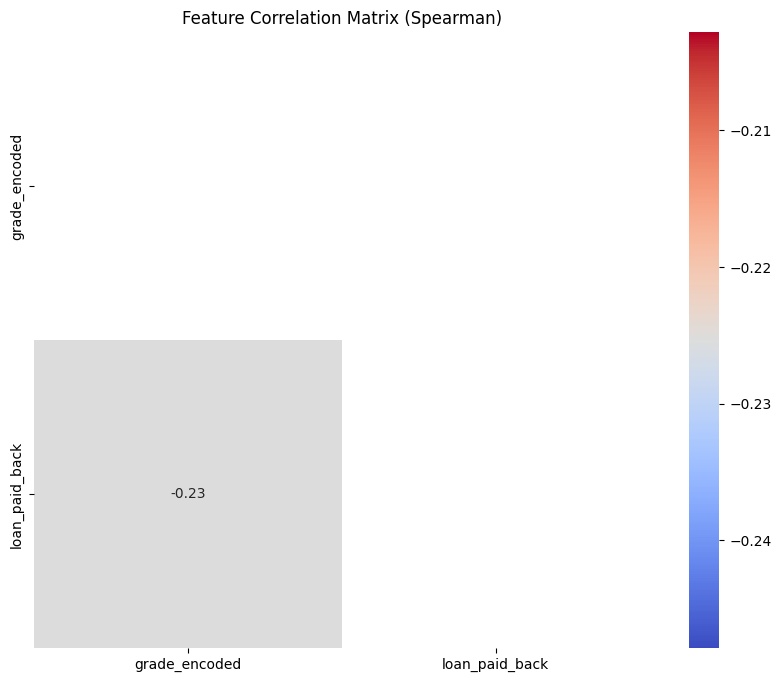

In [20]:
# Create a temporary dataframe for correlation analysis
corr_df = train_df.copy()

# 1. Quick Feature Engineering for EDA: Extract and Encode Grade
# We map A->1, G->7 to check ordinal relationships (Spearman)
if 'grade_subgrade' in corr_df.columns:
    corr_df['grade_temp'] = corr_df['grade_subgrade'].str[0]
    grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
    corr_df['grade_encoded'] = corr_df['grade_temp'].map(grade_map)

# 2. Define Column Groups
continuous_cols = ['annual_income', 'debt_to_income_ratio', 'loan_amount', 'interest_rate', 'credit_score', 'loan_paid_back']
ordinal_cols = ['grade_encoded', 'loan_paid_back']

# 3. Pearson Correlation (Linear Relationships)
print("Pearson Correlation (Continuous Variables):")
plot_correlation_heatmap(corr_df[continuous_cols], method='pearson')

# 4. Spearman Correlation (Monotonic/Ordinal Relationships)
print("Spearman Correlation (Ordinal Variables):")
plot_correlation_heatmap(corr_df[ordinal_cols], method='spearman')

### Scatter Plots
Visualizing the relationship between Income and Loan Amount.

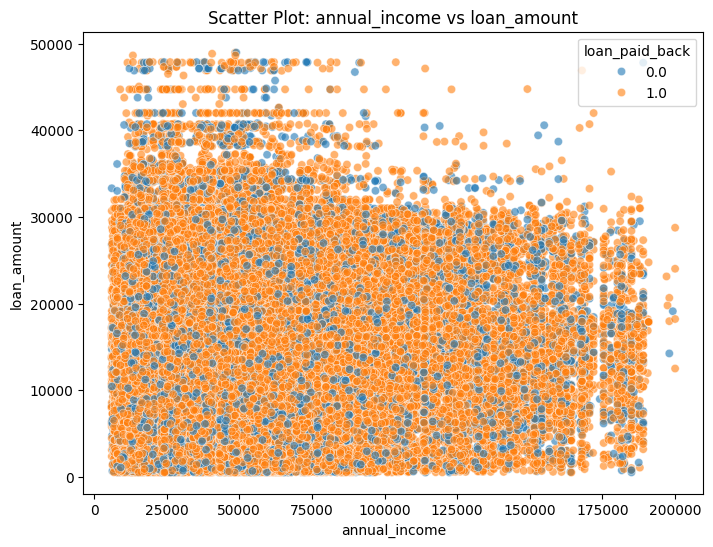

In [15]:
# Filter out extreme outliers for better visualization
temp_df = train_df[train_df['annual_income'] < 200000]
plot_scatter(temp_df, 'annual_income', 'loan_amount', hue='loan_paid_back')

## 6. Key Findings & Next Steps

Based on the visual analysis of the training data, we have established the following strategy:

1.  **Class Imbalance:**  
    * **Observation:** The target variable `loan_paid_back` is highly imbalanced.
    * **Action:** We will use **Stratified Splitting** for validation. For tree-based models, we may use `class_weight='balanced'` or `scale_pos_weight` to penalize misclassifying the minority class.

2.  **Numerical Features (Skewness & Outliers):**
    * **Observation:** `annual_income` is extremely right-skewed with significant outliers visible in the boxplots. `debt_to_income_ratio` also exhibits extreme values.
    * **Action:** We will apply **Log Transformation** (`log1p`) to normalize this distribution, as implemented in our preprocessing module. This helps parametric models handle the variance better.
        * For `annual_income`, we will rely on the robustness of **Ordinal Encoding** (for grades) and **Tree-based models** to handle non-linearities, rather than aggressively removing outliers which might contain signal.

3.  **Categorical High Cardinality:**
    * **Observation:** `grade_subgrade` has high cardinality (35 distinct values).
    * **Action:** We will implement **Concept Hierarchy**: Extract the high-level `grade` (A, B, C...) from `grade_subgrade` and use **Ordinal Encoding** to capture the risk hierarchy ($A < B < G$), then drop the redundant `grade_subgrade` column to avoid multicollinearity.

4.  **Feature Redundancy:**
    * **Observation:** The correlation matrix shows low pairwise correlation between most numerical features.
    * **Action:** No additional feature dropping is required for numerical columns. We will focus on encoding categorical variables correctly.